# Sequence embeddings with with ProtBert

In this Notebook pre-residue sequence embeddings are generated using ProtBert. The embeddings are then used to visualize the sequence similarity of the proteins in the dataset. Furthermore, the sequence data is deposited in a neo4j database, whereas the embeddings are used as vector indices.

__Ressources__:
- [ProtBert](https://huggingface.co/Rostlab/prot_bert)
- [neo4j vector index](https://neo4j.com/docs/cypher-manual/current/indexes/semantic-indexes/vector-indexes/)

In [1]:
import re
import os
import torch
import pandas as pd
import plotly.express as px
import numpy as np
from neo4j import GraphDatabase
from transformers import BertModel, BertTokenizer
from pathlib import Path
from rich.progress import Progress
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from dotenv import load_dotenv

from pyeed.core import ProteinRecord
from pyeed.network import SequenceNetwork

load_dotenv()

True

## Get sequence data from UniProt

Sequence data from EC classes 2.5.1.6 and 2.5.1.7 were obtained from UniProt using BLAST search.

In [2]:
blast = False

if blast:
    p = ProteinRecord.get_id("Q00266")

    seqs = p.ncbi_blast(n_hits=1000)

    # Add sequence id prefix for alphabetical sorting based on blast result 0001, 0002, 0003, ...
    for i, seq in enumerate(seqs):
        seq.id = f"{i:04d}_{seq.id}"

    for seq in seqs:
        with open(f"seqs/{seq.id}.json", "w") as f:
            f.write(seq.json())

else:
    seqs = []
    for path in Path("seqs").rglob("*.json"):
        with open(path) as f:
            seqs.append(ProteinRecord.from_json(f))

## Setup embedding model

In [3]:
# Enable Apple silicon hardware acceleration
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS enabled")
else:
    device = torch.device("cpu")


# Sequences need to be cleard of unknown amino acids
# and amino acids need to be separated by spaces
def preprocess_sequence(sequence):
    sequence = re.sub(r"[UZOB]", "X", sequence)
    sequence = " ".join(sequence)
    return sequence


def get_embeddings(sequences, batch_size=32):
    all_embeddings = []

    # define the model and tokenizer
    model = BertModel.from_pretrained("Rostlab/prot_bert").to(device)
    tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)

    with Progress() as progress:
        task = progress.add_task(
            "[green]Calculating embeddings...", total=len(sequences)
        )

        for i in range(0, len(sequences), batch_size):
            batch = sequences[i : i + batch_size]
            preprocessed_batch = [preprocess_sequence(seq) for seq in batch]

            # Tokenize the sequences
            encoded_input = tokenizer(
                preprocessed_batch, return_tensors="pt", padding=True, truncation=True
            ).to(device)

            # Move encoded input to the device
            encoded_input = {
                key: value.to(device) for key, value in encoded_input.items()
            }

            with torch.no_grad():
                output = model(**encoded_input)

            # Average the token embeddings to get the sequence embedding
            embeddings = output.last_hidden_state.mean(dim=1)

            # Move embeddings back to CPU and collect
            all_embeddings.append(embeddings.cpu())

            progress.update(task, advance=batch_size)

    return torch.cat(all_embeddings)

MPS enabled


## Calculate embeddings

In [4]:
calc_embeddings = False

if calc_embeddings:
    embs = get_embeddings([se.sequence for se in seqs])
    np.save("embs.npy", embs.numpy())
else:
    embs = np.load("embs.npy")

## Visualize embeddings
### T-SNE

In [5]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0, verbose=1)

# Fit and transform data
X_2d = tsne.fit_transform(embs)

# Organize data in a pandas dataframe for swift plotting
lables = [se.id for se in seqs]
names = [se.name for se in seqs]
colors = ["red" if "mat" in se.name else "blue" for se in seqs]

df = pd.DataFrame(X_2d, columns=["x", "y"])
df["labels"] = lables
df["colors"] = colors
df["names"] = names

# Plot the data
fig = px.scatter(df, x="x", y="y", color="names", hover_data=["labels", "names"])
fig.update_traces(marker_size=12)

fig.show(dpi=300)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1073 samples in 0.001s...
[t-SNE] Computed neighbors for 1073 samples in 0.217s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1073
[t-SNE] Computed conditional probabilities for sample 1073 / 1073
[t-SNE] Mean sigma: 0.314098
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.902054
[t-SNE] KL divergence after 1000 iterations: 0.407046


### PCA

In [6]:
pca = PCA(n_components=2)

# Fit and transform data
X_2d = pca.fit_transform(embs)

# Organize data in a pandas dataframe for swift plotting
df = pd.DataFrame(X_2d, columns=["x", "y"])
df["labels"] = lables
df["colors"] = colors
df["names"] = names

fig = px.scatter(df, x="x", y="y", color="names", hover_data=["labels", "names"])

fig.show(dpi=300)

In [7]:
net = SequenceNetwork(sequences=seqs)

Output()

KeyboardInterrupt: 

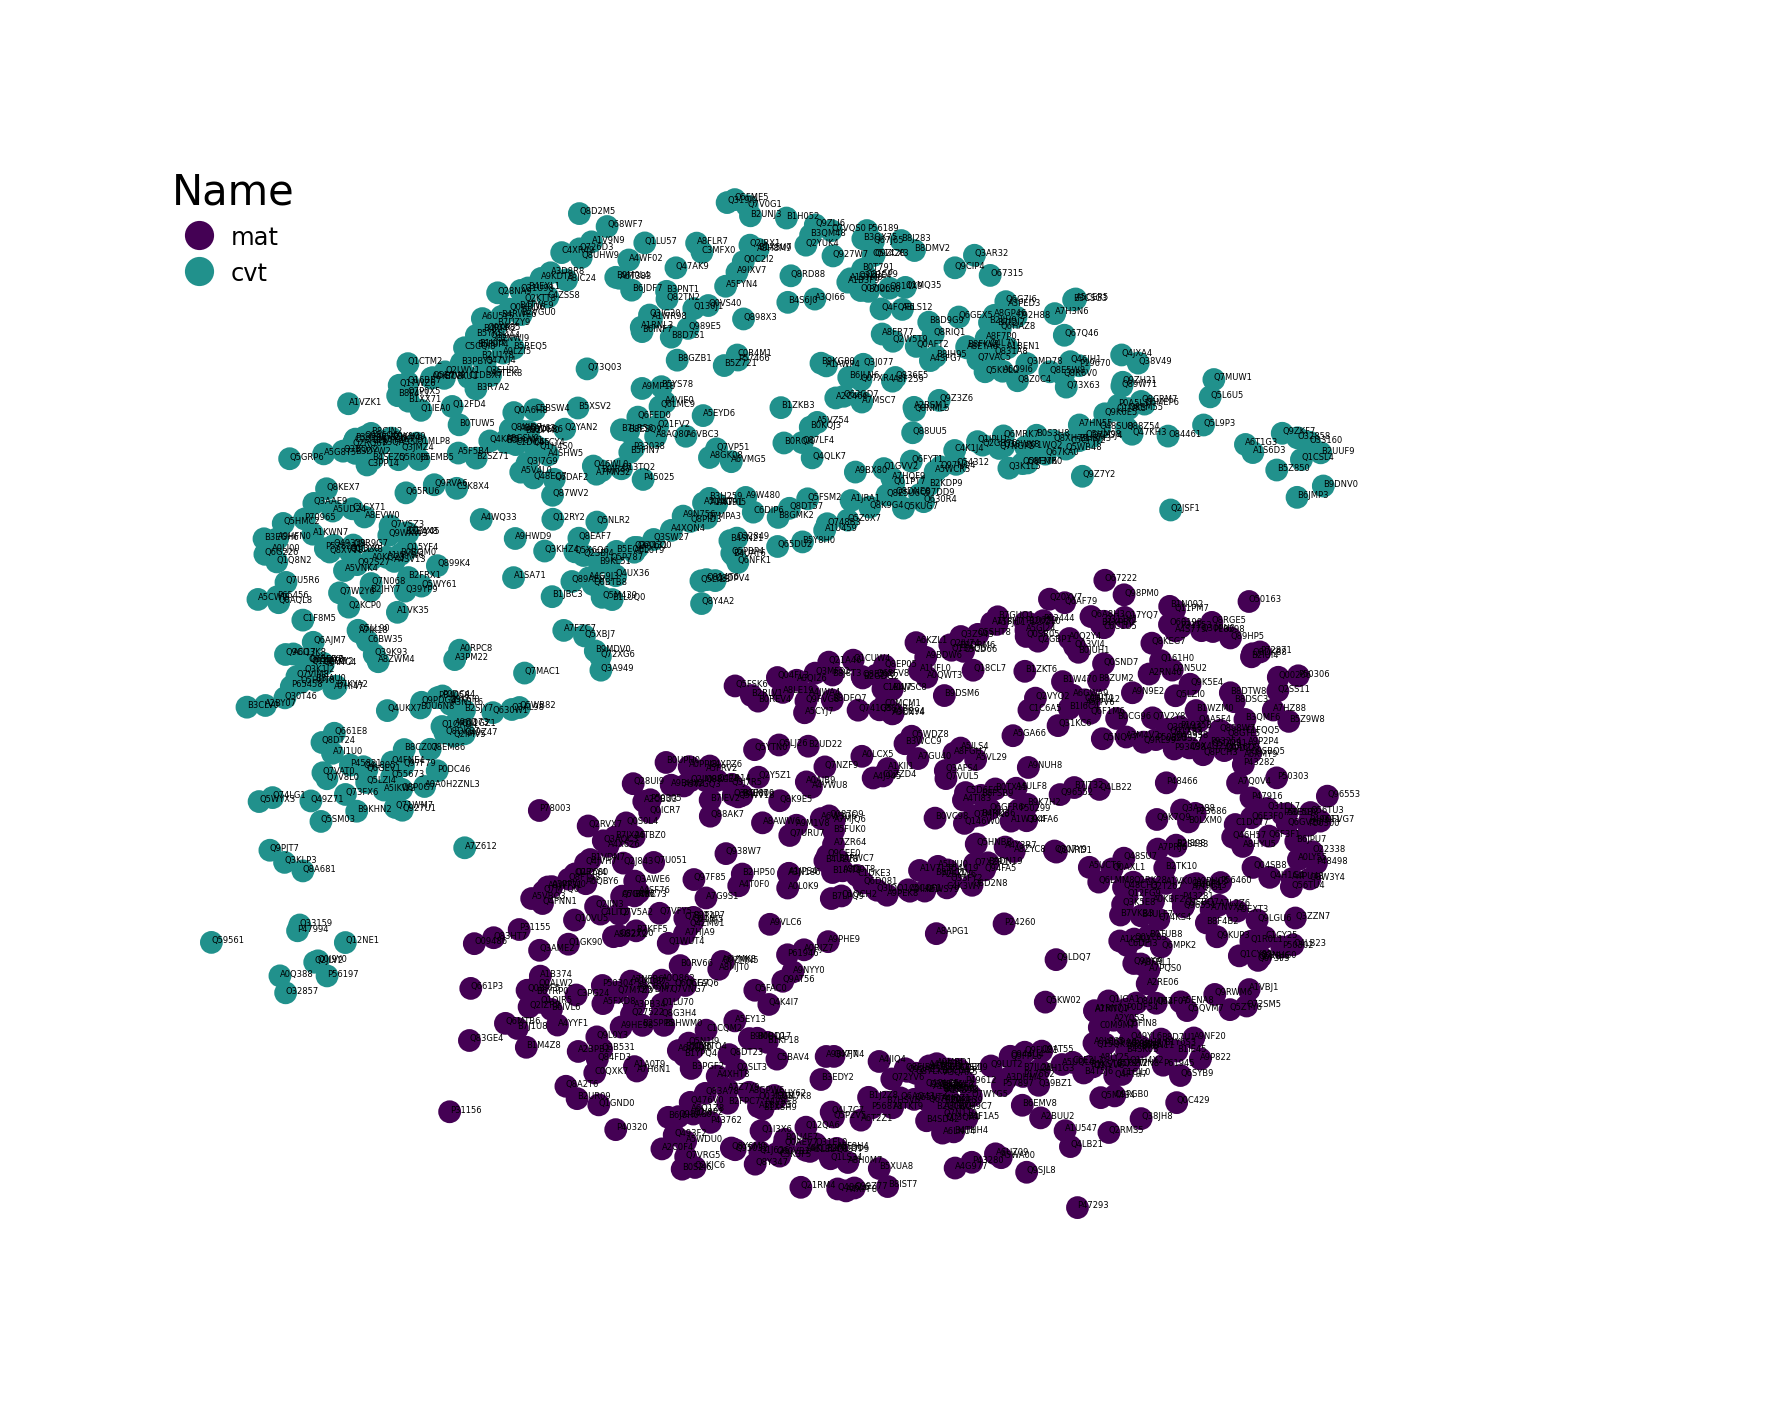

In [ ]:
net.visualize(color="name", edges=False, labels=True)

## Create Graph DB

In [8]:
uri = os.getenv("NEO4J_URI")
user = os.getenv("NEO4J_USER")
password = os.getenv("NEO4J_PASSWORD")

auth = (user, password)

driver = GraphDatabase.driver(uri=uri, auth=auth)

In [9]:
def add_protein(driver, protein: ProteinRecord, embedding):
    return driver.execute_query(
        """
        CREATE (p:Protein {id: $id, name: $name, sequence: $sequence, ec_number: $ec_number, molar_mass: $molar_mass})
        WITH p
        CALL db.create.setNodeVectorProperty(p, 'embedding', $embedding)
        """,
        id=protein.id,
        name=protein.name,
        sequence=protein.sequence,
        ec_number=protein.ec_number,
        embedding=embedding,
        molar_mass=protein.mol_weight,
    )


def add_embedding(driver, protein_id: str, embedding):
    return driver.execute_query(
        """
        MATCH (p:Protein {id: $id})
        CALL db.create.setNodeVectorProperty(p, 'embedding', $embedding)
        """,
        id=protein_id,
        embedding=embedding,
    )


def initialize_vector_index(driver):
    query = """
    CREATE VECTOR INDEX embedding IF NOT EXISTS
    FOR (p:Protein)
    ON p.embedding
    OPTIONS {indexConfig: {
     `vector.dimensions`: 1024,
     `vector.similarity_function`: 'cosine'
    }}
    """

    # Execute the query
    with driver.session() as session:
        session.run(query)


def get_protein_data_as_df(driver, protein_id: str, n_results: int):
    # Define the query
    query = """
    MATCH (p:Protein {id: $protein_id})
    CALL db.index.vector.queryNodes('embedding', $n_results, p.embedding)
    YIELD node, score
    RETURN node.id AS id, score, node.sequence as sequence
    """

    # Execute the query and collect the results
    with driver.session() as session:
        result = session.run(query, protein_id=protein_id, n_results=n_results)
        records = result.data()

    # Convert the result to a pandas DataFrame
    df = pd.DataFrame(records)

    return df

In [ ]:
# make transactions
# code not efficient, neo4j supports batch transactions
# takes approx 3.5 min for 1000 sequences
for seq, emb in zip(seqs, embs):
    add_protein(driver, seq, emb)
    add_embedding(driver, seq.id, emb)

initialize_vector_index(driver)

In [10]:
# get the 100 most similar proteins to protein A7Z612 based on the embeddings
df = get_protein_data_as_df(driver, "A7Z612", 100)
df.head(50)

,id,score,sequence
0,A7Z612,1.000000,MKREKVTSLNGEIHIPGDKSISHRSVMFGALAEGTTTVKNFLPGAD...
1,Q87LF4,0.966989,MEKFRVIGSDKPLVGEVTISGAKNAALPILFASILAEEPVEVANVP...
2,A7MSC7,0.965450,MEKFRVIGSDKPLVGEVTISGAKNAALPILFASILAEEPVEVANVP...
3,P45025,0.963772,MDKFRVYGQSRLSGSVNISGAKNAALPILFAAILATEPVKLTNVPE...
4,Q989E5,0.962406,MDRIRIVGGNKLAGSIPISGAKNAALPLMIASLLTDDTLTLENVPH...
5,A5UIK7,0.962354,MDKFRVYGQSRLSGSVNISGAKNAALPILFAVILATEPVKLTNVPE...
6,Q4QLK7,0.962104,MDKFRVYGQSRLSGSVNISGAKNAALPILFAAILATEPVKLTNVPE...
7,Q7MPA3,0.961871,MEKFRVIGSTQPLMGEVTISGAKNAALPILFASILAEEPVEVANVP...
8,Q8DEB6,0.960743,MEKFRVIGSTQPLVGEVTISGAKNAALPILFASILAEEPVEVANVP...
9,A5F5B4,0.952523,MEKFRVIGSTQPLQGEVTISGAKNAALPILFASILAEEPVEVANVP...
